In [1]:
import os
import sys

chrome_driver_path = os.path.join("C:", 'prjs', 'utils', 'chromedriver', 'chromedriver.exe')
#app_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
#os.environ["PATH"] += os.pathsep + app_path
os.environ["MINIWOB_BASE_URL"] = "file://C:/prjs/miniwob-plusplus/html/"

In [2]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.action import  MiniWoBCoordClick
from miniwob.screenshot import pil_to_numpy_array

task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
env = MiniWoBEnvironment(task_name, seeds=[1], base_url=base_url)
print('BASE URL:', base_url)

BASE URL: file://C:/prjs/miniwob-plusplus/html/


In [3]:
states = env.reset(record_screenshots=True)

In [4]:
states

[MiniWoBState(utterance: 'Click on the "Ok" button.')]

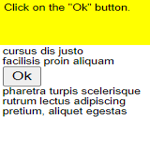

In [5]:
states[0].screenshot.resize([150, 150])

In [6]:
img = pil_to_numpy_array(states[0].screenshot)
img.shape

(210, 160, 3)

In [7]:
states[0].dom.visualize()

"- [1] body @ (0, 0) classes=[NO_CLASS] children=1\n  |- [2] div @ (0, 0) classes=[NO_CLASS] children=1\n     |- [3] div @ (0, 50) classes=[NO_CLASS] children=6\n        |- [4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]\n        |- [5] div @ (2, 63.2) text='facilisis proin aliq...' classes=[NO_CLASS]\n        |- [6] button @ (2, 74.4) text='Ok' classes=[NO_CLASS]\n        |- [7] div @ (2, 96.4) text='pharetra turpis scel...' classes=[NO_CLASS]\n        |- [8] div @ (2, 107.6) text='rutrum lectus adipis...' classes=[NO_CLASS]\n        |- [9] div @ (2, 118.8) text='pretium, aliquet ege...' classes=[NO_CLASS]"

In [8]:
states[0].dom.is_leaf

False

In [9]:
states[0].dom

[1] body @ (0, 0) classes=[NO_CLASS] children=1

In [10]:
states[0].tokens

['Click', 'on', 'the', '"', 'Ok', '"', 'button', '.']

In [11]:
env.step([MiniWoBCoordClick(10, 57)])

([MiniWoBState(utterance: 'Click on the "Ok" button.')],
 [0.0],
 [False],
 {'n': [{'done': False,
    'env_reward': 0,
    'raw_reward': 0,
    'reason': None,
    'elapsed': 4.146000623703003}]})

In [12]:
env.close()

# Gym miniwob wrapper

In [13]:
import gym
import torch

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel

class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        self.dom_tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size, (8, ),
                                                                              dtype=np.int64),
                                                  "img_state": gym.spaces.Box(0,
                                                                        255,
                                                                        (150, 150, 3),
                                                                        dtype=np.uint8),
                                                  "dom_state": gym.spaces.Box(0,
                                                                        self.dom_tokenizer.vocab_size,
                                                                        (16, ), dtype=np.int64)})
        
        self.action_space = gym.spaces.Box(low=0, high=200, shape=(2, ), dtype=np.int32)

    def observation(self, obs):
        goal = self.tokenizer(obs.tokens,  padding='max_length', 
                       max_length = 8, truncation=True,          
                       return_tensors="pt",
                       is_split_into_words=True)['input_ids']
        img = torch.tensor(pil_to_numpy_array(obs.screenshot.resize([150, 150]))).unsqueeze(0)
        
        #dom = self.dom_tokenizer(obs.dom.visualize(),  padding='max_length', 
        #               max_length = 8, truncation=True,          
        #               return_tensors="pt")['input_ids']
        
        dom = self.dom_tokenizer.tokenize(obs.dom.visualize())[:16]
        dom_str = "website DOM-tree"
        dom_str_tokens = self.dom_tokenizer.tokenize(dom_str)
        dom = [self.dom_tokenizer.cls_token] + dom_str_tokens + [self.dom_tokenizer.sep_token] \
              + dom + [self.dom_tokenizer.sep_token] + [self.dom_tokenizer.pad_token] * 16
        dom = self.dom_tokenizer.convert_tokens_to_ids(dom[:16])
        dom = torch.tensor(dom, dtype=torch.int64).unsqueeze(0)
        
        #state = {"img": img,
        #         "dom": dom}

        return {'img_state': img, 'dom_state': dom, 'goal_state': goal}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True)[0])
    
    def step(self, action):
        action = action.abs() * 210.
        action[:, 0] = torch.clamp(action[:, 0], min=0, max=210)
        action[:, 1] = torch.clamp(action[:, 1], min=0, max=160)
        action = action.int()
        miniwob_action = [MiniWoBCoordClick(*tuple(action.numpy()[0, :]))]
        obs, reward, done, info = self.env.step(miniwob_action)
        if done[0]:
            return None, reward[0], done[0], info
        else:
            return self.observation(obs[0]), reward[0], done[0], info
        
class EpisodeInfoWrapper(gym.Wrapper):
    
    def __init__(self, env):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = 0
        self.episode_steps = 0

    def reset(self):
        self.episode_reward = 0
        self.episode_steps = 0
        return self.env.reset()

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        self.episode_reward += reward
        self.episode_steps += 1
        if done:   
            info['episode'] = {'r': self.episode_reward, 'steps': self.episode_steps}
        return state, reward, done, info

# Bert encoder

In [14]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
import torch

class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        self.output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.output_size, 
                            num_layers=2)
        
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
        
        output, _ = self.lstm(embeds)
        return output[-1]

# DOM Encoder

In [16]:
class DomEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.bert_encoder = RobertaModel.from_pretrained("microsoft/codebert-base")
        self.embed_dim = 768
        self.output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=self.output_size, 
                            num_layers=2)
        
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return output[-1]


class Encoder(nn.Module):
    def __init__(self, img, dom):
        super(Encoder, self).__init__()
        self.img_encoder = img
        self.dom_encoder = dom
        self.output_size = self.dom_encoder.output_size + self.img_encoder.output_size
    
    def forward(self, img_state, dom_state):
        img_out = self.img_encoder(img_state)
        dom_out = self.dom_encoder(dom_state)
        out = torch.cat([img_out, dom_out], dim=-1)
        return out

# Train agent

In [17]:
import numpy as np
from rllr.env.vec_wrappers import make_vec_envs
from stable_baselines3.common.vec_env import DummyVecEnv


def gen_env(env_id):
    env = MiniWoBEnvironment(task_name, seeds=[env_id], base_url=base_url)
    env = MiniWobClickButtonWrapper(env)
    return EpisodeInfoWrapper(env)

In [18]:
env = gen_env(1)

In [19]:
from rllr.models.encoders import GoalStateEncoder, SimpleCNN

conf = {
    "n_channels": [32, 64, 64],
    "kernel_sizes": [4, 4, 3],
    "strides": [4, 2, 1],
    "hidden_layers_sizes": [128]
}

img_encoder = SimpleCNN(grid_size=150, conf=conf)
dom_encoder = DomEncoder()
state_encoder = Encoder(img_encoder, dom_encoder)
goal_encoder = BertEncoder()
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(env.action_space, encoder, encoder, hidden_size, hidden_size)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)

In [21]:
from rllr.buffer.rollout import RolloutStorage
from tqdm import trange
import time
from collections import deque

def update_linear_schedule(optimizer, epoch, total_num_epochs, initial_lr):
    """Decreases the learning rate linearly"""
    lr = initial_lr - (initial_lr * (epoch / float(total_num_epochs)))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train_agent(agent, env, conf):

    rollouts = RolloutStorage(
            conf['training.n_steps'], conf['training.n_processes'], env.observation_space, env.action_space
        )
    
    obs = env.reset()
    rollouts.set_first_obs(obs)
    rollouts.to(conf['agent.device'])

    start = time.time()
    num_updates = int(conf['training.n_env_steps'] // conf['training.n_steps'] // conf['training.n_processes'])

    episode_rewards = deque(maxlen=10)

    for j in trange(num_updates):
        update_linear_schedule(agent.optimizer, j, num_updates, conf['agent.lr'])

        for step in range(conf['training.n_steps']):
            # Sample actions
            value, action, action_log_prob = agent.act(obs)
            obs, reward, done, info = env.step(action)
            
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])
                
            if done:
                obs = env.reset()
                continue

            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in [done]])
            reward = torch.FloatTensor([reward])
            
            rollouts.insert(obs, action, action_log_prob, value, reward, masks)
            
    
        next_value = agent.get_value(rollouts.get_last_obs())
        rollouts.compute_returns(next_value, conf['agent.gamma'], conf['agent.gae_lambda'])

        value_loss, action_loss, dist_entropy = agent.update(rollouts)
        
        if j % conf['training.verbose'] == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * conf['training.n_processes'] * conf['training.n_steps']
            end = time.time()
            print(f'Updates {j}, '
                  f'num timesteps {total_num_steps}, '
                  f'FPS {int(total_num_steps / (end - start))} \n'
                  f'Last {len(episode_rewards)} training episodes: '
                  f'mean/median reward {np.mean(episode_rewards):.2f}/{np.median(episode_rewards):.2f}, '
                  f'min/max reward {np.min(episode_rewards):.2f}/{np.max(episode_rewards):.2f}\n'
                  f'dist_entropy {dist_entropy:.2f}, '
                  f'value_loss {value_loss:.2f}, '
                          f'action_loss {action_loss:.2f}')

In [22]:
train_conf = {
    "agent.lr": 0.001,
    "agent.device": "cpu",
    "agent.gamma": 0.99,
    "agent.gae_lambda": 0.95,
    "training.n_env_steps": 100,
    "training.n_steps": 10,
    "training.n_processes": 1,
    "training.verbose": 2,
}


train_agent(agent, env, train_conf)

 30%|████████████████████████▉                                                          | 3/10 [00:42<01:40, 14.38s/it]

Updates 2, num timesteps 30, FPS 0 
Last 3 training episodes: mean/median reward -1.00/-1.00, min/max reward -1.00/-1.00
dist_entropy 3.58, value_loss 0.00, action_loss -0.09


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:16<01:19, 15.92s/it]

Updates 4, num timesteps 50, FPS 0 
Last 5 training episodes: mean/median reward -1.00/-1.00, min/max reward -1.00/-1.00
dist_entropy 3.60, value_loss 0.00, action_loss -0.01


 70%|██████████████████████████████████████████████████████████                         | 7/10 [01:50<00:49, 16.54s/it]

Updates 6, num timesteps 70, FPS 0 
Last 7 training episodes: mean/median reward -1.00/-1.00, min/max reward -1.00/-1.00
dist_entropy 3.61, value_loss 0.00, action_loss -0.03


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [02:28<00:17, 17.80s/it]

Updates 8, num timesteps 90, FPS 0 
Last 9 training episodes: mean/median reward -1.00/-1.00, min/max reward -1.00/-1.00
dist_entropy 3.61, value_loss 0.00, action_loss -0.01


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/it]


In [23]:
env.close()